In [1]:
%matplotlib inline
from coffea import hist
from coffea.analysis_objects import JaggedCandidateArray
import coffea.processor as processor

In [2]:
# This program will graph the sum of Jet pT's which are greater than 30 GeV and farther than a Euclidean distance of 0.4 from any lepton with pT > 10 GeV.
class Processor(processor.ProcessorABC):
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "")
        muon_axis = hist.Bin("Jet_pt", "Jet_pt [GeV]", 100, 15, 200)
        
        self._accumulator = processor.dict_accumulator({
            'Jet_pt': hist.Hist("Counts", dataset_axis, muon_axis),
            'cutflow': processor.defaultdict_accumulator(int)
        })
    
    @property
    def accumulator(self):
        return self._accumulator
    
    def process(self, events):
        output = self.accumulator.identity()
        
        dataset = events.metadata["dataset"]

        muons = events.Muon
        electrons = events.Electron
        jets = events.Jet
        
        output['cutflow']['all events'] += jets.size
        output['cutflow']['all jets'] += jets.counts.sum()
        
        # Get jets with higher GeV than 30.
        min_jetpt = (jets.pt > 30)
        output['cutflow']['jets with pt > 30'] += min_jetpt.sum().sum()
        
        # Get all leptons with higher GeV than 10.
        min_muonpt = (muons.pt > 10)
        output['cutflow']['muons with pt > 10'] += min_muonpt.sum().sum()
        min_electronpt = (electrons.pt > 10)
        output['cutflow']['electrons with pt > 10'] += min_electronpt.sum().sum()
        
        # Mask jets and leptons with their minimum requirements/
        goodjets = jets[min_jetpt]
        goodmuons = muons[min_muonpt]
        goodelectrons = electrons[min_electronpt]
        
        # Cross is like distincts, but across multiple JCA's. So we cross jets with each lepton to generate all (jet, lepton) pairs. We have nested=True so that all jet values are stored in sublists together, and thus maintain uniqueness so we can get them back later.
        jet_muon_pairs = goodjets.cross(goodmuons, nested=True)
        jet_electron_pairs = goodjets.cross(goodelectrons, nested=True)
    
        # This long conditional checks that the jet is at least 0.4 euclidean distance from each lepton. It then checks if each unique jet contains a False, i.e., that a jet is 0.4 euclidean distance from EVERY specific lepton in the event.
        good_jm_pairs = (jet_muon_pairs.i0.delta_r(jet_muon_pairs.i1) > 0.4).all()
        good_je_pairs = (jet_electron_pairs.i0.delta_r(jet_electron_pairs.i1) > 0.4).all()
        
        output['cutflow']['jet-muon pairs'] += good_jm_pairs.sum().sum()
        output['cutflow']['jet-electron pairs'] += good_je_pairs.sum().sum()
        output['cutflow']['jet-lepton pairs'] += (good_jm_pairs & good_je_pairs).sum().sum()
        
        # We then mask our jets with all three of the above good pairs to get only jets that are 0.4 distance from every type of lepton, and sum them.
        sumjets = goodjets[good_jm_pairs & good_je_pairs].pt.sum()
        output['cutflow']['final jets'] += goodjets[good_jm_pairs & good_je_pairs].counts.sum()
        output['Jet_pt'].fill(dataset=dataset, Jet_pt=sumjets.flatten())
        
        return output

    def postprocess(self, accumulator):
        return accumulator

In [3]:
fileset = {'SingleMu': ["data/Run2012B_SingleMu.root"]}
output = processor.run_uproot_job(fileset,
                                 treename='Events',
                                 processor_instance=Processor(),
                                 executor=processor.futures_executor,
                                 executor_args={'workers':4, 'nano': True},
                                 chunksize = 250000)

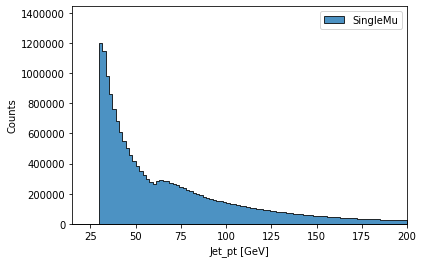

In [4]:
hist.plot1d(output['Jet_pt'], overlay='dataset', fill_opts={'edgecolor': (0,0,0,0.3), 'alpha': 0.8})

In [5]:
for key, value in output['cutflow'].items():
    print(key, value)

all events 53446198
all jets 170952895
jets with pt > 30 37461601
muons with pt > 10 58440651
electrons with pt > 10 5483772
jet-muon pairs 28103661
jet-electron pairs 33916050
jet-lepton pairs 25397925
final jets 25397925
